5. 삼성전자 주식 다음달 가격 얼마일까?(회귀)
6. 비트코인 다음달 어떻게 될까?(회귀)
7. 전날 비트코인 상승하면 다음날 주가와의 상관관계(Correlation)

1. 목표
 1. Y : 미래 30일의 국내 특정주식, 비트코인의 종가 
 1. X : 최근 60일간의 데이터
   1. step : 하루 간격
   1. 양 : 1년(2018년 6월  ~ 2019년 6월)
1. 데이터 획득
   1. 국내 기업 1개, 비트코인
1. 데이터 정제
   1. 누락
1. 데이터 전처리
   1. 특수기호, 문자 > 수치 변환
   1. 두 데이터 날짜 기준으로 통합(axis=1)
     1. 외국(2018-01-01), 국내(2018.1.1.)(18.1.1)
     1. 날짜 포맷을 (yyyy-mm-dd)으로 변환 후 통합
1. 비트코인 가격 변화와 주가와의 상관관계 
   1. cov()
1. 입력 X/ 출력 Y 분리
   1. m개의 x,y 쌍
   1. x(m, 60, 10-15(국내증시컬럼 + 비트코인컬럼)) > reshape > (m, 60*15)
   1. y(m, 30, 2) > (m, 30*2)
1. 학습용/검증용(test)분리 
   1. 섞으면 안되므로 직접 분리
   1. 가장 과거의 데이터 10%를 검증용으로 사용
1. 모델 선정
   1. Ridge 모델. 학습용 데이터로 학습
   1. 성능 측정
1. 그래프로 시각화
   1. 과거
   1. 미래의 예측 predict(x(1,60*15) ) > return > y_hat(1,30*2)
      1. 미래 예측(1, 30 *2) > (30,2) > 국내(30), 비트코인(30) > 그래프로 그리기
      

국내 기업 데이터 획득

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
samsung_url = 'https://finance.naver.com/item/sise_day.nhn?code=005930'

In [15]:
tables = pd.read_html(samsung_url+'&page='+str(1))
len(tables)
samsung = tables[0]
samsung.shape

(15, 7)

In [30]:
samsungs =[]

for i in range(1, 28):
    tables = pd.read_html(samsung_url+'&page='+str(i))
    samsung = tables[0]
    samsungs.append(samsung)
len(samsungs)

27

In [31]:
samsung = pd.concat(samsungs)
samsung = samsung.set_index('날짜')
# samsung.dropna(axis=0 ,how('any'))
samsung.shape, samsung

((405, 6),                  종가     전일비       시가       고가       저가         거래량
 날짜                                                                
 NaN             NaN     NaN      NaN      NaN      NaN         NaN
 2019.07.03  45750.0   500.0  45750.0  46350.0  45600.0   3560549.0
 2019.07.02  46250.0   350.0  46200.0  46900.0  45850.0   8463073.0
 2019.07.01  46600.0   400.0  47350.0  47400.0  46250.0  11383522.0
 2019.06.28  47000.0   500.0  47000.0  47000.0  46700.0  12949231.0
 2019.06.27  46500.0   800.0  46000.0  46600.0  45750.0  12603534.0
 NaN             NaN     NaN      NaN      NaN      NaN         NaN
 NaN             NaN     NaN      NaN      NaN      NaN         NaN
 NaN             NaN     NaN      NaN      NaN      NaN         NaN
 2019.06.26  45700.0   100.0  45800.0  46000.0  45600.0   9226097.0
 2019.06.25  45600.0   100.0  45200.0  45800.0  45200.0   7076774.0
 2019.06.24  45500.0   200.0  45200.0  45800.0  45200.0   6085066.0
 2019.06.21  45700.0   200.0  45750.0 

In [17]:
samsung = samsung.set_index('날짜')
samsung

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019.07.03,45700.0,550.0,45750.0,46350.0,45600.0,3315682.0
2019.07.02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
2019.07.01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0
2019.06.28,47000.0,500.0,47000.0,47000.0,46700.0,12949231.0
2019.06.27,46500.0,800.0,46000.0,46600.0,45750.0,12603534.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
bitcoin_url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20180601&end=20190601'
bit_tables = pd.read_html(bitcoin_url)

In [40]:
len(bit_tables)

2

In [38]:
bitcoin = bit_tables[0]
bitcoin = bitcoin.set_index('Date')

In [51]:
#인덱스 타입이 object
bitcoin.index = pd.to_datetime(bitcoin.index) #비트코인의 인덱스를 날짜로 바꾸기
samsung.index = pd.to_datetime(samsung.index)

데이터 통합

In [57]:
df = pd.concat((samsung,bitcoin), axis=1).dropna()

In [61]:
df.describe()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
count,244.000000,244.000000,244.000000,244.000000,244.000000,2.440000e+02,244.000000,244.000000,244.000000,244.000000,2.440000e+02,2.440000e+02
mean,44541.393443,524.590164,44541.393443,44982.786885,44080.122951,1.127346e+07,5598.614672,5708.022869,5487.953197,5597.538361,8.087400e+09,9.730654e+10
std,2616.501077,445.496251,2663.568359,2616.332608,2605.084532,3.923683e+06,1514.608753,1542.730010,1476.931675,1512.541132,6.225952e+09,2.597773e+10
min,37450.000000,0.000000,37450.000000,37600.000000,36850.000000,4.762460e+06,3253.120000,3329.560000,3206.540000,3242.480000,3.230550e+09,5.649438e+10
25%,43012.500000,200.000000,43012.500000,43437.500000,42400.000000,8.298381e+06,3957.602500,4031.850000,3899.502500,3956.197500,4.324805e+09,6.936442e+10
50%,44975.000000,400.000000,44925.000000,45500.000000,44500.000000,1.079669e+07,6205.425000,6300.355000,6029.725000,6179.620000,5.304537e+09,1.064328e+11
75%,46362.500000,762.500000,46462.500000,46850.000000,46000.000000,1.305694e+07,6599.830000,6743.025000,6498.092500,6601.707500,9.347169e+09,1.140496e+11
max,51300.000000,2200.000000,51800.000000,51800.000000,50700.000000,2.625465e+07,8802.760000,9008.310000,8668.700000,8805.780000,3.316720e+10,1.560938e+11


전날 비트 코인 상승하면 다음날 주가와의 상관관계(correlation)

In [65]:
비트코인변화 = df['Open*'] - df['Close**']
주가변화 = df['시가'] - df['종가']
과거비트코인변화 = 비트코인변화.iloc[:-1]
다음날주가변화 = 주가변화.iloc[1:]


In [69]:
np.corrcoef(과거비트코인변화, 다음날주가변화) # 상관계수가 0에 가까우므로 둘은 상관관계가 거의 없습니다. 
plt.scatter(과거비트코인변화, 다음날주가변화)

array([[ 1.        , -0.07316871],
       [-0.07316871,  1.        ]])

In [71]:

input_seq = 60
output_seq = 30
m = len(df) - (input_seq + output_seq) +1
len(df), m

(244, 155)

In [75]:
x_list = []
y_list = []
for i in range(m):
    x = df.iloc[i:i+input_seq]
    y = df.iloc[i+input_seq:i + input_seq+output_seq][['종가','Close**']]
    x_list.append(x)
    y_list.append(y)
    #print(x.shape, y.shape)


In [93]:
len(x_list), type(x_list) #(155,60,12)
#numpy array 로 변환
m =len(x_3d)
x_2d = np.reshape(x_3d,[m,-1])
y_2d = np.reshape(y_3d, [m,-1])

x_3d = np.stack(x_list, axis=0)
y_3d = np.stack(y_list, axis=0)
x_3d.shape, y_3d.shape

((155, 60, 12), (155, 30, 2))

In [84]:
df.columns

Index(['종가', '전일비', '시가', '고가', '저가', '거래량', 'Open*', 'High', 'Low', 'Close**',
       'Volume', 'Market Cap'],
      dtype='object')

train/test 분리
- test 10%

In [88]:
test_ratio = 0.1
test_m = int(len(x_3d)*test_ratio)
test_m

15

In [94]:
x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

In [117]:
#model, Linea regression, 가중치를 작게 제약시킨다. > 모든 정보를 활용해서 예측
from sklearn.linear_model import Ridge
model = Ridge(normalize=True, solver='lsqr').fit(x_train, y_train) #2차원 이하만 가능

In [118]:
model.score(x_train, y_train), model.score(x_test, y_test)# 과적함 발생

(0.9736899384676927, -11.805314083668307)

In [119]:
korea_close_index = 0
bitcoin_close_index = 9

In [120]:
#가장 최근데이터 
recent = df.iloc[-input_seq:]
recent.shape
recent = np.reshape(np.array(recent), [1,-1])
recent.shape

(1, 720)

In [121]:
p = model.predict(recent)#미래예측
p = np.reshape(p,[output_seq, -1])
p.shape, p

((30, 2), array([[48924.26230114,  7982.28310556],
        [49040.61295094,  7940.94143005],
        [48604.02398172,  7908.47361629],
        [47807.81825774,  8035.79523344],
        [47189.63438344,  8183.05529563],
        [46524.10307846,  7873.52700351],
        [46908.88020791,  7659.3197307 ],
        [47798.37036834,  7362.49911165],
        [48203.79476845,  7114.72327915],
        [48830.43431439,  7140.48499864],
        [48854.48850643,  7194.46831024],
        [48398.83216242,  7164.48706904],
        [48255.70096705,  7283.79902861],
        [47392.31009506,  7382.26858071],
        [46955.71694167,  7494.37778905],
        [47128.04213411,  8431.95585969],
        [46798.28392945,  9166.01252608],
        [46348.52069804,  9760.22664049],
        [45153.4258817 ,  9863.55193349],
        [43716.82698978,  9605.58392954],
        [42782.86163088,  9678.36968954],
        [43134.3306429 ,  9687.64465096],
        [43289.82546926,  9387.01212787],
        [43421.01199763, 

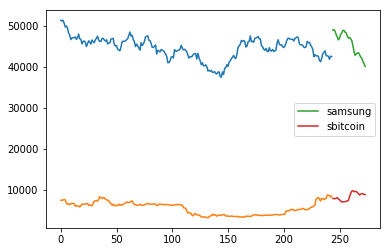

In [122]:
xm = len(df)
plt.plot(np.arange(xm), df['종가'].values)
plt.plot(np.arange(xm),df['Close**'].values)
plt.plot(np.arange(xm, xm+output_seq),p[:,0], label = 'samsung')
plt.plot(np.arange(xm, xm+output_seq),p[:,1], label = 'sbitcoin')
plt.legend()